In [1]:
import os
os.environ["SM_FRAMEWORK"] = "tf.keras"
import albumentations as albu
import segmentation_models as sm
import tensorflow as tf
import numpy as np
from matplotlib import pyplot as plt
import cv2
from model import ModelCreator
from datapipeline import DatasetCreator
import shutil

Segmentation Models: using `tf.keras` framework.


In [2]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [3]:
height = 512

In [4]:
modelcreator = ModelCreator()
model = modelcreator.buildmodel()
model.compile('Adam', loss=sm.losses.bce_jaccard_loss, metrics=[sm.metrics.iou_score])

KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 3), dtype=tf.float32, name='input_1'), name='input_1', description="created by layer 'input_1'")
KerasTensor(type_spec=TensorSpec(shape=(None, 512, 512, 1), dtype=tf.float32, name=None), name='conv2d_transpose_6/Sigmoid:0', description="created by layer 'conv2d_transpose_6'")


In [5]:
val_transforms = albu.Compose([
    albu.Resize(height, height),  # Ensuring your input is always of size 256x256
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [6]:
valdataset = DatasetCreator(modelcreator.getpreprocess(),val_transforms)

In [7]:
valdata = valdataset('crosval/val/*png','castom-masks/masks_machine/')
len(valdata)

8

In [8]:
trainaugmentation = albu.Compose([
    albu.Resize(height, height),
    albu.HorizontalFlip(p=0.5),
    albu.VerticalFlip(p=0.5),
    albu.RandomRotate90(p=0.5),
    albu.Transpose(p=0.5),
    albu.ShiftScaleRotate(shift_limit=0.01, scale_limit=0.04, rotate_limit=15, p=0.5),
    albu.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    albu.GridDistortion(p=0.5),  # Non-linear distortion
    albu.HueSaturationValue(hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=0.5),
    albu.RandomBrightnessContrast(p=0.5),
    albu.RandomGamma(p=0.5),
    albu.GaussianBlur(blur_limit=(3, 7), p=0.5),
    albu.GaussNoise(),
    albu.CLAHE(clip_limit=4.0, tile_grid_size=(8, 8), always_apply=False, p=0.5), 
    albu.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])#todo change later

In [9]:
traindataset = DatasetCreator(modelcreator.getpreprocess(),trainaugmentation)

In [10]:
traindata = traindataset('crosval/train/*png','castom-masks/masks_machine/')
len(traindata)

18

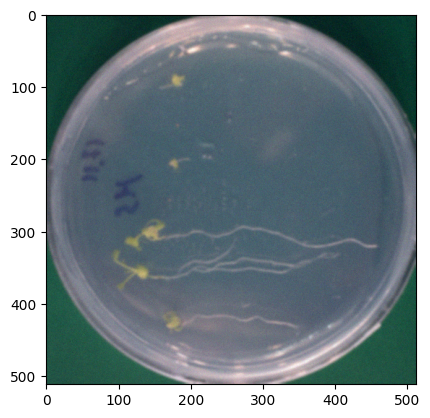

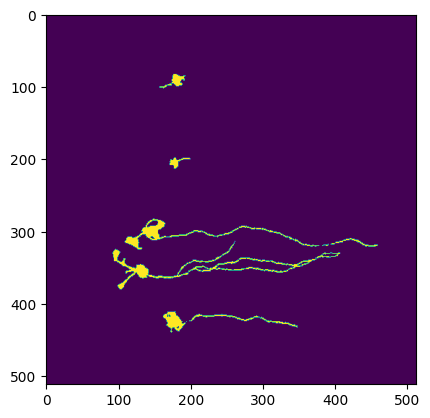

In [11]:
for image,mask in traindata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

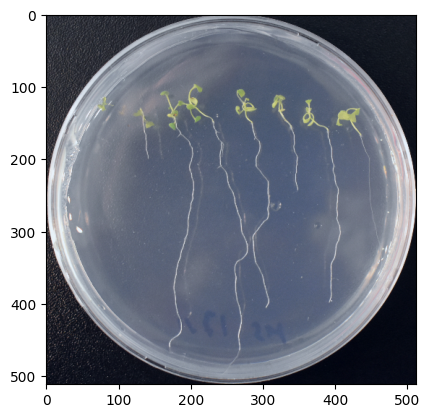

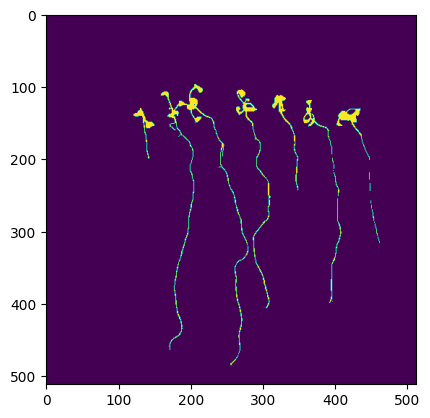

In [12]:
for image,mask in valdata.take(1):
        plt.imshow(tf.keras.utils.array_to_img(image[0]))
        plt.pause(1)
        plt.imshow(tf.keras.utils.array_to_img(mask[0]))

In [13]:
#tf.keras.utils.plot_model(model)

In [14]:
def scheduler(epoch, lr):
    return lr * tf.math.exp(-0.1) if epoch > 15 and epoch % 15 == 0 else lr

callback =[
    tf.keras.callbacks.EarlyStopping(min_delta=0.0001,patience=30,verbose=1),
    tf.keras.callbacks.LearningRateScheduler(scheduler,verbose=1),
    tf.keras.callbacks.ModelCheckpoint(filepath='bestmodel/',save_best_only=True,monitor='val_loss',verbose=1)
]

In [15]:
# fit model
model_history = model.fit(
    traindata,
    epochs=1000,
    validation_data=valdata,
    callbacks=callback,
    )


Epoch 1: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 1/1000
18/18 [==============================] - ETA: 0s - loss: 1.5548 - iou_score: 0.0097
Epoch 1: val_loss improved from inf to 1.47970, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 30s 862ms/step - loss: 1.5548 - iou_score: 0.0097 - val_loss: 1.4797 - val_iou_score: 0.0098 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 2/1000
18/18 [==============================] - ETA: 0s - loss: 1.1327 - iou_score: 0.0105
Epoch 2: val_loss improved from 1.47970 to 1.15248, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 691ms/step - loss: 1.1327 - iou_score: 0.0105 - val_loss: 1.1525 - val_iou_score: 0.0061 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 3/1000
18/18 [==============================] - ETA: 0s - loss: 1.0714 - iou_score: 0.0131
Epoch 3: val_loss improved from 1.15248 to 1.10692, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 691ms/step - loss: 1.0714 - iou_score: 0.0131 - val_loss: 1.1069 - val_iou_score: 0.0070 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 4/1000
18/18 [==============================] - ETA: 0s - loss: 1.0492 - iou_score: 0.0199
Epoch 4: val_loss did not improve from 1.10692
18/18 [==============================] - 14s 294ms/step - loss: 1.0492 - iou_score: 0.0199 - val_loss: 1.1331 - val_iou_score: 0.0099 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 5/1000
18/18 [==============================] - ETA: 0s - loss: 1.0251 - iou_score: 0.0326
Epoch 5: val_loss did not improve from 1.10692
18/18 [==============================] - 14s 293ms/step - loss: 1.0251 - iou_score: 0.0326 - val_loss: 1.1234 - val_iou_score: 0.0105 - lr: 0.0010

Epoch 6: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 6/1000
18/18 [===========

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 688ms/step - loss: 0.9957 - iou_score: 0.0589 - val_loss: 1.1003 - val_iou_score: 0.0105 - lr: 0.0010

Epoch 7: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 7/1000
18/18 [==============================] - ETA: 0s - loss: 0.9919 - iou_score: 0.0616
Epoch 7: val_loss improved from 1.10027 to 1.08054, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 690ms/step - loss: 0.9919 - iou_score: 0.0616 - val_loss: 1.0805 - val_iou_score: 0.0099 - lr: 0.0010

Epoch 8: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 8/1000
18/18 [==============================] - ETA: 0s - loss: 0.9586 - iou_score: 0.0894
Epoch 8: val_loss improved from 1.08054 to 1.06671, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 691ms/step - loss: 0.9586 - iou_score: 0.0894 - val_loss: 1.0667 - val_iou_score: 0.0093 - lr: 0.0010

Epoch 9: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 9/1000
18/18 [==============================] - ETA: 0s - loss: 0.9286 - iou_score: 0.1143
Epoch 9: val_loss improved from 1.06671 to 1.05852, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 702ms/step - loss: 0.9286 - iou_score: 0.1143 - val_loss: 1.0585 - val_iou_score: 0.0087 - lr: 0.0010

Epoch 10: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 10/1000
18/18 [==============================] - ETA: 0s - loss: 0.8833 - iou_score: 0.1507
Epoch 10: val_loss improved from 1.05852 to 1.05289, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 692ms/step - loss: 0.8833 - iou_score: 0.1507 - val_loss: 1.0529 - val_iou_score: 0.0085 - lr: 0.0010

Epoch 11: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 11/1000
18/18 [==============================] - ETA: 0s - loss: 0.8614 - iou_score: 0.1748
Epoch 11: val_loss improved from 1.05289 to 1.05127, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 693ms/step - loss: 0.8614 - iou_score: 0.1748 - val_loss: 1.0513 - val_iou_score: 0.0067 - lr: 0.0010

Epoch 12: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 12/1000
18/18 [==============================] - ETA: 0s - loss: 0.7911 - iou_score: 0.2417
Epoch 12: val_loss did not improve from 1.05127
18/18 [==============================] - 14s 293ms/step - loss: 0.7911 - iou_score: 0.2417 - val_loss: 1.0541 - val_iou_score: 0.0058 - lr: 0.0010

Epoch 13: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 13/1000
18/18 [==============================] - ETA: 0s - loss: 0.7777 - iou_score: 0.2554
Epoch 13: val_loss did not improve from 1.05127
18/18 [==============================] - 14s 291ms/step - loss: 0.7777 - iou_score: 0.2554 - val_loss: 1.0519 - val_iou_score: 0.0062 - lr: 0.0010

Epoch 14: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 14/1000
18/18 [===

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 710ms/step - loss: 0.7111 - iou_score: 0.3230 - val_loss: 1.0504 - val_iou_score: 0.0088 - lr: 0.0010

Epoch 17: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 17/1000
18/18 [==============================] - ETA: 0s - loss: 0.7153 - iou_score: 0.3227
Epoch 17: val_loss improved from 1.05044 to 1.04157, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 23s 717ms/step - loss: 0.7153 - iou_score: 0.3227 - val_loss: 1.0416 - val_iou_score: 0.0154 - lr: 0.0010

Epoch 18: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 18/1000
18/18 [==============================] - ETA: 0s - loss: 0.7030 - iou_score: 0.3286
Epoch 18: val_loss improved from 1.04157 to 1.03760, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 22s 715ms/step - loss: 0.7030 - iou_score: 0.3286 - val_loss: 1.0376 - val_iou_score: 0.0199 - lr: 0.0010

Epoch 19: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 19/1000
18/18 [==============================] - ETA: 0s - loss: 0.7018 - iou_score: 0.3355
Epoch 19: val_loss improved from 1.03760 to 1.00124, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 22s 710ms/step - loss: 0.7018 - iou_score: 0.3355 - val_loss: 1.0012 - val_iou_score: 0.0521 - lr: 0.0010

Epoch 20: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 20/1000
18/18 [==============================] - ETA: 0s - loss: 0.6734 - iou_score: 0.3582
Epoch 20: val_loss improved from 1.00124 to 0.99970, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 22s 706ms/step - loss: 0.6734 - iou_score: 0.3582 - val_loss: 0.9997 - val_iou_score: 0.0597 - lr: 0.0010

Epoch 21: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 21/1000
18/18 [==============================] - ETA: 0s - loss: 0.6661 - iou_score: 0.3718
Epoch 21: val_loss improved from 0.99970 to 0.95673, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 22s 718ms/step - loss: 0.6661 - iou_score: 0.3718 - val_loss: 0.9567 - val_iou_score: 0.0903 - lr: 0.0010

Epoch 22: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 22/1000
18/18 [==============================] - ETA: 0s - loss: 0.6693 - iou_score: 0.3693
Epoch 22: val_loss did not improve from 0.95673
18/18 [==============================] - 14s 300ms/step - loss: 0.6693 - iou_score: 0.3693 - val_loss: 0.9810 - val_iou_score: 0.0808 - lr: 0.0010

Epoch 23: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 23/1000
18/18 [==============================] - ETA: 0s - loss: 0.6735 - iou_score: 0.3634
Epoch 23: val_loss did not improve from 0.95673
18/18 [==============================] - 15s 299ms/step - loss: 0.6735 - iou_score: 0.3634 - val_loss: 0.9690 - val_iou_score: 0.0983 - lr: 0.0010

Epoch 24: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 24/1000
18/18 [===

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 22s 714ms/step - loss: 0.7106 - iou_score: 0.3295 - val_loss: 0.8698 - val_iou_score: 0.1804 - lr: 0.0010

Epoch 26: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 26/1000
18/18 [==============================] - ETA: 0s - loss: 0.6393 - iou_score: 0.3972
Epoch 26: val_loss improved from 0.86980 to 0.79026, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 22s 711ms/step - loss: 0.6393 - iou_score: 0.3972 - val_loss: 0.7903 - val_iou_score: 0.2513 - lr: 0.0010

Epoch 27: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 27/1000
18/18 [==============================] - ETA: 0s - loss: 0.6432 - iou_score: 0.3881
Epoch 27: val_loss did not improve from 0.79026
18/18 [==============================] - 14s 305ms/step - loss: 0.6432 - iou_score: 0.3881 - val_loss: 0.8185 - val_iou_score: 0.2335 - lr: 0.0010

Epoch 28: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 28/1000
18/18 [==============================] - ETA: 0s - loss: 0.6708 - iou_score: 0.3653
Epoch 28: val_loss improved from 0.79026 to 0.73749, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 712ms/step - loss: 0.6708 - iou_score: 0.3653 - val_loss: 0.7375 - val_iou_score: 0.3105 - lr: 0.0010

Epoch 29: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 29/1000
18/18 [==============================] - ETA: 0s - loss: 0.6454 - iou_score: 0.3903
Epoch 29: val_loss did not improve from 0.73749
18/18 [==============================] - 14s 297ms/step - loss: 0.6454 - iou_score: 0.3903 - val_loss: 0.7468 - val_iou_score: 0.2883 - lr: 0.0010

Epoch 30: LearningRateScheduler setting learning rate to 0.0010000000474974513.
Epoch 30/1000
18/18 [==============================] - ETA: 0s - loss: 0.6475 - iou_score: 0.3852
Epoch 30: val_loss improved from 0.73749 to 0.68502, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 715ms/step - loss: 0.6475 - iou_score: 0.3852 - val_loss: 0.6850 - val_iou_score: 0.3644 - lr: 0.0010

Epoch 31: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 31/1000
18/18 [==============================] - ETA: 0s - loss: 0.6557 - iou_score: 0.3782
Epoch 31: val_loss improved from 0.68502 to 0.66809, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 22s 722ms/step - loss: 0.6557 - iou_score: 0.3782 - val_loss: 0.6681 - val_iou_score: 0.3730 - lr: 9.0484e-04

Epoch 32: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 32/1000
18/18 [==============================] - ETA: 0s - loss: 0.6087 - iou_score: 0.4250
Epoch 32: val_loss did not improve from 0.66809
18/18 [==============================] - 15s 303ms/step - loss: 0.6087 - iou_score: 0.4250 - val_loss: 0.6729 - val_iou_score: 0.3590 - lr: 9.0484e-04

Epoch 33: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 33/1000
18/18 [==============================] - ETA: 0s - loss: 0.6329 - iou_score: 0.4020
Epoch 33: val_loss improved from 0.66809 to 0.61452, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 710ms/step - loss: 0.6329 - iou_score: 0.4020 - val_loss: 0.6145 - val_iou_score: 0.4205 - lr: 9.0484e-04

Epoch 34: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 34/1000
18/18 [==============================] - ETA: 0s - loss: 0.6183 - iou_score: 0.4122
Epoch 34: val_loss did not improve from 0.61452
18/18 [==============================] - 14s 302ms/step - loss: 0.6183 - iou_score: 0.4122 - val_loss: 0.6351 - val_iou_score: 0.4086 - lr: 9.0484e-04

Epoch 35: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 35/1000
18/18 [==============================] - ETA: 0s - loss: 0.6294 - iou_score: 0.4033
Epoch 35: val_loss improved from 0.61452 to 0.59765, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 713ms/step - loss: 0.6294 - iou_score: 0.4033 - val_loss: 0.5977 - val_iou_score: 0.4466 - lr: 9.0484e-04

Epoch 36: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 36/1000
18/18 [==============================] - ETA: 0s - loss: 0.6020 - iou_score: 0.4353
Epoch 36: val_loss improved from 0.59765 to 0.56356, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 691ms/step - loss: 0.6020 - iou_score: 0.4353 - val_loss: 0.5636 - val_iou_score: 0.4749 - lr: 9.0484e-04

Epoch 37: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 37/1000
18/18 [==============================] - ETA: 0s - loss: 0.6109 - iou_score: 0.4240
Epoch 37: val_loss improved from 0.56356 to 0.54967, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 686ms/step - loss: 0.6109 - iou_score: 0.4240 - val_loss: 0.5497 - val_iou_score: 0.4846 - lr: 9.0484e-04

Epoch 38: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 38/1000
18/18 [==============================] - ETA: 0s - loss: 0.6118 - iou_score: 0.4241
Epoch 38: val_loss improved from 0.54967 to 0.54873, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 693ms/step - loss: 0.6118 - iou_score: 0.4241 - val_loss: 0.5487 - val_iou_score: 0.4832 - lr: 9.0484e-04

Epoch 39: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 39/1000
18/18 [==============================] - ETA: 0s - loss: 0.6174 - iou_score: 0.4200
Epoch 39: val_loss improved from 0.54873 to 0.53882, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 690ms/step - loss: 0.6174 - iou_score: 0.4200 - val_loss: 0.5388 - val_iou_score: 0.4788 - lr: 9.0484e-04

Epoch 40: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 40/1000
18/18 [==============================] - ETA: 0s - loss: 0.6166 - iou_score: 0.4165
Epoch 40: val_loss did not improve from 0.53882
18/18 [==============================] - 15s 291ms/step - loss: 0.6166 - iou_score: 0.4165 - val_loss: 0.5559 - val_iou_score: 0.4821 - lr: 9.0484e-04

Epoch 41: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 41/1000
18/18 [==============================] - ETA: 0s - loss: 0.5937 - iou_score: 0.4390
Epoch 41: val_loss improved from 0.53882 to 0.52473, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 688ms/step - loss: 0.5937 - iou_score: 0.4390 - val_loss: 0.5247 - val_iou_score: 0.5131 - lr: 9.0484e-04

Epoch 42: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 42/1000
18/18 [==============================] - ETA: 0s - loss: 0.5911 - iou_score: 0.4433
Epoch 42: val_loss did not improve from 0.52473
18/18 [==============================] - 14s 296ms/step - loss: 0.5911 - iou_score: 0.4433 - val_loss: 0.5407 - val_iou_score: 0.4854 - lr: 9.0484e-04

Epoch 43: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 43/1000
18/18 [==============================] - ETA: 0s - loss: 0.6133 - iou_score: 0.4245
Epoch 43: val_loss improved from 0.52473 to 0.51372, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 691ms/step - loss: 0.6133 - iou_score: 0.4245 - val_loss: 0.5137 - val_iou_score: 0.5226 - lr: 9.0484e-04

Epoch 44: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 44/1000
18/18 [==============================] - ETA: 0s - loss: 0.5985 - iou_score: 0.4372
Epoch 44: val_loss did not improve from 0.51372
18/18 [==============================] - 14s 293ms/step - loss: 0.5985 - iou_score: 0.4372 - val_loss: 0.5236 - val_iou_score: 0.5015 - lr: 9.0484e-04

Epoch 45: LearningRateScheduler setting learning rate to 0.0009048373904079199.
Epoch 45/1000
18/18 [==============================] - ETA: 0s - loss: 0.5927 - iou_score: 0.4421
Epoch 45: val_loss improved from 0.51372 to 0.51354, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 687ms/step - loss: 0.5927 - iou_score: 0.4421 - val_loss: 0.5135 - val_iou_score: 0.5219 - lr: 9.0484e-04

Epoch 46: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 46/1000
18/18 [==============================] - ETA: 0s - loss: 0.5942 - iou_score: 0.4376
Epoch 46: val_loss did not improve from 0.51354
18/18 [==============================] - 13s 292ms/step - loss: 0.5942 - iou_score: 0.4376 - val_loss: 0.5346 - val_iou_score: 0.5008 - lr: 8.1873e-04

Epoch 47: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 47/1000
18/18 [==============================] - ETA: 0s - loss: 0.5911 - iou_score: 0.4435
Epoch 47: val_loss improved from 0.51354 to 0.49886, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 680ms/step - loss: 0.5911 - iou_score: 0.4435 - val_loss: 0.4989 - val_iou_score: 0.5349 - lr: 8.1873e-04

Epoch 48: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 48/1000
18/18 [==============================] - ETA: 0s - loss: 0.6086 - iou_score: 0.4258
Epoch 48: val_loss did not improve from 0.49886
18/18 [==============================] - 14s 291ms/step - loss: 0.6086 - iou_score: 0.4258 - val_loss: 0.5153 - val_iou_score: 0.5255 - lr: 8.1873e-04

Epoch 49: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 49/1000
18/18 [==============================] - ETA: 0s - loss: 0.6034 - iou_score: 0.4335
Epoch 49: val_loss improved from 0.49886 to 0.48815, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 690ms/step - loss: 0.6034 - iou_score: 0.4335 - val_loss: 0.4882 - val_iou_score: 0.5444 - lr: 8.1873e-04

Epoch 50: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 50/1000
18/18 [==============================] - ETA: 0s - loss: 0.5840 - iou_score: 0.4479
Epoch 50: val_loss improved from 0.48815 to 0.48297, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 682ms/step - loss: 0.5840 - iou_score: 0.4479 - val_loss: 0.4830 - val_iou_score: 0.5513 - lr: 8.1873e-04

Epoch 51: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 51/1000
18/18 [==============================] - ETA: 0s - loss: 0.5970 - iou_score: 0.4305
Epoch 51: val_loss did not improve from 0.48297
18/18 [==============================] - 14s 289ms/step - loss: 0.5970 - iou_score: 0.4305 - val_loss: 0.5014 - val_iou_score: 0.5324 - lr: 8.1873e-04

Epoch 52: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 52/1000
18/18 [==============================] - ETA: 0s - loss: 0.5759 - iou_score: 0.4584
Epoch 52: val_loss improved from 0.48297 to 0.47773, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 689ms/step - loss: 0.5759 - iou_score: 0.4584 - val_loss: 0.4777 - val_iou_score: 0.5580 - lr: 8.1873e-04

Epoch 53: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 53/1000
18/18 [==============================] - ETA: 0s - loss: 0.5742 - iou_score: 0.4602
Epoch 53: val_loss did not improve from 0.47773
18/18 [==============================] - 14s 291ms/step - loss: 0.5742 - iou_score: 0.4602 - val_loss: 0.4869 - val_iou_score: 0.5415 - lr: 8.1873e-04

Epoch 54: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 54/1000
18/18 [==============================] - ETA: 0s - loss: 0.5678 - iou_score: 0.4650
Epoch 54: val_loss did not improve from 0.47773
18/18 [==============================] - 14s 289ms/step - loss: 0.5678 - iou_score: 0.4650 - val_loss: 0.5171 - val_iou_score: 0.5230 - lr: 8.1873e-04

Epoch 55: LearningRateScheduler setting learning rate to 0.0008187306812033057.
Epoch 55/100

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 693ms/step - loss: 0.5852 - iou_score: 0.4519 - val_loss: 0.4738 - val_iou_score: 0.5631 - lr: 7.4082e-04

Epoch 68: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 68/1000
18/18 [==============================] - ETA: 0s - loss: 0.6106 - iou_score: 0.4235
Epoch 68: val_loss did not improve from 0.47380
18/18 [==============================] - 15s 291ms/step - loss: 0.6106 - iou_score: 0.4235 - val_loss: 0.4916 - val_iou_score: 0.5485 - lr: 7.4082e-04

Epoch 69: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 69/1000
18/18 [==============================] - ETA: 0s - loss: 0.5872 - iou_score: 0.4485
Epoch 69: val_loss improved from 0.47380 to 0.47107, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 682ms/step - loss: 0.5872 - iou_score: 0.4485 - val_loss: 0.4711 - val_iou_score: 0.5634 - lr: 7.4082e-04

Epoch 70: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 70/1000
18/18 [==============================] - ETA: 0s - loss: 0.5540 - iou_score: 0.4741
Epoch 70: val_loss did not improve from 0.47107
18/18 [==============================] - 13s 290ms/step - loss: 0.5540 - iou_score: 0.4741 - val_loss: 0.4791 - val_iou_score: 0.5547 - lr: 7.4082e-04

Epoch 71: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 71/1000
18/18 [==============================] - ETA: 0s - loss: 0.5914 - iou_score: 0.4483
Epoch 71: val_loss did not improve from 0.47107
18/18 [==============================] - 14s 288ms/step - loss: 0.5914 - iou_score: 0.4483 - val_loss: 0.4806 - val_iou_score: 0.5549 - lr: 7.4082e-04

Epoch 72: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 72/1000
1

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 690ms/step - loss: 0.5812 - iou_score: 0.4542 - val_loss: 0.4630 - val_iou_score: 0.5557 - lr: 7.4082e-04

Epoch 73: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 73/1000
18/18 [==============================] - ETA: 0s - loss: 0.5520 - iou_score: 0.4802
Epoch 73: val_loss improved from 0.46296 to 0.46084, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 686ms/step - loss: 0.5520 - iou_score: 0.4802 - val_loss: 0.4608 - val_iou_score: 0.5666 - lr: 7.4082e-04

Epoch 74: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 74/1000
18/18 [==============================] - ETA: 0s - loss: 0.5587 - iou_score: 0.4723
Epoch 74: val_loss did not improve from 0.46084
18/18 [==============================] - 14s 288ms/step - loss: 0.5587 - iou_score: 0.4723 - val_loss: 0.4797 - val_iou_score: 0.5504 - lr: 7.4082e-04

Epoch 75: LearningRateScheduler setting learning rate to 0.000740818097256124.
Epoch 75/1000
18/18 [==============================] - ETA: 0s - loss: 0.5700 - iou_score: 0.4669
Epoch 75: val_loss did not improve from 0.46084
18/18 [==============================] - 13s 288ms/step - loss: 0.5700 - iou_score: 0.4669 - val_loss: 0.4694 - val_iou_score: 0.5639 - lr: 7.4082e-04

Epoch 76: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 76/1000
1

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 683ms/step - loss: 0.5707 - iou_score: 0.4636 - val_loss: 0.4505 - val_iou_score: 0.5779 - lr: 6.7032e-04

Epoch 80: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 80/1000
18/18 [==============================] - ETA: 0s - loss: 0.5581 - iou_score: 0.4740
Epoch 80: val_loss did not improve from 0.45047
18/18 [==============================] - 14s 292ms/step - loss: 0.5581 - iou_score: 0.4740 - val_loss: 0.4566 - val_iou_score: 0.5790 - lr: 6.7032e-04

Epoch 81: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 81/1000
18/18 [==============================] - ETA: 0s - loss: 0.5415 - iou_score: 0.4904
Epoch 81: val_loss did not improve from 0.45047
18/18 [==============================] - 13s 287ms/step - loss: 0.5415 - iou_score: 0.4904 - val_loss: 0.4736 - val_iou_score: 0.5586 - lr: 6.7032e-04

Epoch 82: LearningRateScheduler setting learning rate to 0.000670319888740778.
Epoch 82/1000
1

INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 20s 684ms/step - loss: 0.5610 - iou_score: 0.4723 - val_loss: 0.4493 - val_iou_score: 0.5791 - lr: 6.7032e-04

Epoch 91: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 91/1000
18/18 [==============================] - ETA: 0s - loss: 0.5521 - iou_score: 0.4781
Epoch 91: val_loss did not improve from 0.44929
18/18 [==============================] - 15s 289ms/step - loss: 0.5521 - iou_score: 0.4781 - val_loss: 0.4737 - val_iou_score: 0.5568 - lr: 6.0653e-04

Epoch 92: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 92/1000
18/18 [==============================] - ETA: 0s - loss: 0.5571 - iou_score: 0.4757
Epoch 92: val_loss improved from 0.44929 to 0.44074, saving model to bestmodel\


INFO:tensorflow:Assets written to: bestmodel\assets


INFO:tensorflow:Assets written to: bestmodel\assets


18/18 [==============================] - 21s 687ms/step - loss: 0.5571 - iou_score: 0.4757 - val_loss: 0.4407 - val_iou_score: 0.5875 - lr: 6.0653e-04

Epoch 93: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 93/1000
18/18 [==============================] - ETA: 0s - loss: 0.5547 - iou_score: 0.4796
Epoch 93: val_loss did not improve from 0.44074
18/18 [==============================] - 13s 287ms/step - loss: 0.5547 - iou_score: 0.4796 - val_loss: 0.4654 - val_iou_score: 0.5625 - lr: 6.0653e-04

Epoch 94: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 94/1000
18/18 [==============================] - ETA: 0s - loss: 0.5442 - iou_score: 0.4858
Epoch 94: val_loss did not improve from 0.44074
18/18 [==============================] - 14s 285ms/step - loss: 0.5442 - iou_score: 0.4858 - val_loss: 0.4707 - val_iou_score: 0.5620 - lr: 6.0653e-04

Epoch 95: LearningRateScheduler setting learning rate to 0.0006065304623916745.
Epoch 95/100

In [16]:
testdata = valdataset('crosval/test/*png','castom-masks/masks_machine/',batch_size=1)

In [17]:
results = model.evaluate(testdata)
results

9/9 [==============================] - 2s 26ms/step - loss: 0.4423 - iou_score: 0.5875


[0.4423142075538635, 0.5874971151351929]

In [18]:
i = 0

if os.path.isdir('output/'):
    shutil.rmtree('output/')
os.makedirs('output/')

for image,truemask in testdata.take(len(testdata)):
    mask = model.predict((tf.reshape(image,[1,height,height,3])))
    mask = tf.keras.utils.array_to_img(mask[0])
    img = tf.keras.utils.array_to_img(image[0])
    img = cv2.cvtColor(np.array(img),cv2.COLOR_BGR2RGB)
    mask = cv2.cvtColor(np.array(mask),cv2.COLOR_GRAY2RGB)
    vis = np.concatenate((img, mask), axis=1)
    i+=1
    cv2.imwrite('output/'+str(i)+'.png', vis)

1/1 [==============================] - 0s 21ms/step
